# Modelado v2.0 - Datos del log y resumidos de entregas y notas de las actividades
---

En este notebook , se desarrolla la segunda iteración del modelado, en la cual se explora el funcionamiento de los cuatro modelos probados en la anterior iteración, pero utilizando un dataset nuevo, el cual contiene la misma cantidad de instancias (los 201 estudiantes del curso durante el año 23/24) pero features diferentes. Estas features recopilan información de acceso de los alumnos al curso, y dos columnas asociadas a las actividades de evaluación continua, la proporción de entregas realizadas del total disponibles, y la nota media obtenida en ellas. 

Cabe destacar que la fecha de corte considerada para separar las ventanas ha seguido siendo la misma utilizada para todo el proyecto. 

La principal motivación detras de probar el rendimiento de los modelos sobre este conjunto de datos es ver si pueden ofrecer un rendimiento mejor, dado que son métricas con las cuales podríamos generalizar mejor en un futuro a otras asignaturas, dado que son adaptables para cualquier aula que exigiera una interacción frecuente con el aula virtual y tuviera la misma proporción de alumnos y abandonos. 

In [4]:
# Core
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Modelado
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, roc_auc_score,
                                           precision_score, recall_score,
                                           make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

# Desbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

import joblib, os

#----------Rutas de los datos----------
DATA_PATH = '/home/carlos/Documentos/TFG/spark-workspace/data/datasets/'

# --- Carpeta donde guardaremos los modelos entrenados ---
MODEL_PATH = "models_v2.0"
os.makedirs(MODEL_PATH, exist_ok=True)


## Carga de datos 


In [5]:
df = pd.read_parquet(f"{DATA_PATH}/dataset_2.0.parquet")

# 4. Separar X / y
X = df.drop(columns=["userid", "abandona"])
y = df["abandona"]

display(df.head(3))
print("X shape:", X.shape)
print(X.info())

,userid,nota_media_actividades,proporcion_actividades_hechas,num_accesos,num_accesos_sept,num_accesos_oct,num_accesos_nov,max_dias_sin_acceso,max_dias_consecutivos_accediendo,abandona
0,e1f1d0f48ca77093f9d66cefd325504245277db3e6c145...,8.416667,0.857143,183,63,81,39,5,12,0
1,b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484db...,8.892857,1.000000,149,53,58,38,6,7,0
2,90a634296aff946e9d045997d512d2b77dbc01880715c1...,8.380953,1.000000,102,31,40,31,6,6,1


X shape: (201, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nota_media_actividades            201 non-null    float64
 1   proporcion_actividades_hechas     201 non-null    float64
 2   num_accesos                       201 non-null    int64  
 3   num_accesos_sept                  201 non-null    int64  
 4   num_accesos_oct                   201 non-null    int64  
 5   num_accesos_nov                   201 non-null    int64  
 6   max_dias_sin_acceso               201 non-null    int32  
 7   max_dias_consecutivos_accediendo  201 non-null    int64  
dtypes: float64(2), int32(1), int64(5)
memory usage: 11.9 KB
None


## Definir pipeline de los modelos tradicionales

In [9]:
# --- Preprocesador único: escala todas las columnas ---
preprocessor = ColumnTransformer(
      [("scaler", StandardScaler(), X.columns)],
      remainder="passthrough",
)


def make_pipeline(name: str, use_smote: bool):
    """
    Devuelve (pipeline, ruta_a_guardar) según el nombre del modelo y si aplicamos SMOTE.
    Todos usan el mismo 'preprocessor'.
    """
    # Selección de clasificador base
    if name == "LogReg":
        clf = LogisticRegression(class_weight="balanced", max_iter=1000)
    elif name == "Tree":
        clf = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    elif name == "XGB":
        ratio = (y == 0).sum() / (y == 1).sum()
        clf = XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            scale_pos_weight=y.value_counts()[0] / y.value_counts()[1],
            random_state=42,
        )
    else:
        raise ValueError(f"Modelo desconocido: {name}")

    # Montamos el pipeline
    steps = [("pre", preprocessor)]
    if use_smote:
        steps.append(("smote", SMOTE()))
    steps.append(("clf", clf))

    pipe = ImbPipeline(steps) if use_smote else Pipeline(steps)

    # Definimos nombre de fichero donde guardarlo
    suffix = "_smote" if use_smote else ""
    fname = os.path.join(MODEL_PATH, f"{name.lower()}{suffix}.pkl")
    return pipe, fname

## Evaluación + guardado de los 3 modelos “tradicionales”

In [10]:
# ============================================================
# 1) Cross-validation, métricas y guardado de modelos clásicos
# ============================================================
import os, joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate


scoring = ["f1", "roc_auc", "precision", "recall"]

def evaluate_and_save(name: str, use_smote: bool = False):
    """
    - Ejecuta CV estratificada (5 folds) con las métricas de interés.
    - Re-entrena el pipeline con TODO el dataset.
    - Guarda el pipeline en disco.
    - Devuelve un dict con medias ± std de las métricas y la ruta al .pkl.
    """
    pipe, fname = make_pipeline(name, use_smote)
    cvres = cross_validate(
        pipe, X, y, cv=5, scoring=scoring, return_train_score=False
    )
    metrics = {m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
               for m in scoring}

    # Reentrenamos sobre X, y completos y almacenamos
    pipe.fit(X, y)
    joblib.dump(pipe, fname)

    return {"model": f"{name}{'+SMOTE' if use_smote else ''}", "file": fname, **metrics}

# Ejecutamos para LR, Árbol y XGB (con y sin SMOTE)
results = []
for mdl in ["LogReg", "Tree", "XGB"]:
    results.append(evaluate_and_save(mdl, use_smote=False))
    results.append(evaluate_and_save(mdl, use_smote=True))

# Construir DataFrame de métricas
rows = []
for r in results:
    row = {"model": r["model"]}
    for m in scoring:
        mean, std = r[m]
        row[m] = f"{mean:.3f} ± {std:.3f}"
    rows.append(row)

res_df = pd.DataFrame(rows).set_index("model")
display(res_df)


,f1,roc_auc,precision,recall
model,,,,
LogReg,0.520 ± 0.055,0.816 ± 0.028,0.471 ± 0.094,0.605 ± 0.076
LogReg+SMOTE,0.546 ± 0.056,0.811 ± 0.025,0.477 ± 0.096,0.690 ± 0.146
Tree,0.539 ± 0.125,0.722 ± 0.090,0.639 ± 0.102,0.510 ± 0.203
Tree+SMOTE,0.405 ± 0.053,0.649 ± 0.036,0.390 ± 0.047,0.429 ± 0.078
XGB,0.514 ± 0.214,0.827 ± 0.104,0.542 ± 0.204,0.510 ± 0.256
XGB+SMOTE,0.544 ± 0.154,0.819 ± 0.082,0.464 ± 0.127,0.667 ± 0.209


 ## Cross-validation de la Red Neuronal (solo métricas + curva de AUC por época)


In [11]:
# ============================================================
# CV de la Red Neuronal con/sin SMOTE (5 folds, DataFrame)
# ============================================================
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# --- 1) Construcción del wrapper Keras idéntico al de Modelado.py ----
def build_model(meta, units=64, dr=0.3):
    n_features = meta["n_features_in_"]
    model = Sequential([
        Dense(units, activation="relu", input_shape=(n_features,)),
        Dropout(dr),
        Dense(units // 2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

ratio = y.value_counts()[0] / y.value_counts()[1]
nn_clf = KerasClassifier(
    model=build_model,
    epochs=60,
    batch_size=16,
    verbose=0,
    fit__class_weight={0: 1, 1: ratio},
    random_state=42
)

# --- 2) Pipelines: sin SMOTE y con SMOTE --------------------------
pipe_no = Pipeline([
    ("pre", preprocessor),
    ("nn",  nn_clf)
])
pipe_sm = ImbPipeline([
    ("pre",   preprocessor),
    ("smote", SMOTE()),
    ("nn",    nn_clf)
])

# --- 3) Cross‐validation para ambos ----------------------------------
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "roc_auc", "precision", "recall"]

results = {}
for name, pipe in [("NN", pipe_no), ("NN+SMOTE", pipe_sm)]:
    cvres = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    # guardar mean/std de cada métrica
    results[name] = {
        m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
        for m in scoring
    }

# --- 4) Montar DataFrame final ---------------------------------------
df = pd.DataFrame({
    name: {metric: f"{mean:.3f} ± {std:.3f}"
           for metric, (mean, std) in mets.items()}
    for name, mets in results.items()
})

# --- 5) Mostrar resultados ------------------------------------------
print("Neural Network – 5-fold CV (métricas mean ± std)")
display(df)


2025-06-21 20:35:20.179386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 20:35:20.179382: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 20:35:20.180945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 20:35:20.181011: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 20:35:20.185225: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your

Neural Network – 5-fold CV (métricas mean ± std)


,NN,NN+SMOTE
f1,0.477 ± 0.201,0.396 ± 0.188
roc_auc,0.778 ± 0.147,0.772 ± 0.157
precision,0.392 ± 0.170,0.294 ± 0.148
recall,0.619 ± 0.256,0.619 ± 0.271


## Visualizaciones de LR


LR Coefficients:


,feature,coef
5,scaler__num_accesos_nov,-1.534899
1,scaler__proporcion_actividades_hechas,-0.902383
4,scaler__num_accesos_oct,0.870326
7,scaler__max_dias_consecutivos_accediendo,-0.211148
2,scaler__num_accesos,-0.164064
6,scaler__max_dias_sin_acceso,-0.140923
3,scaler__num_accesos_sept,-0.034572
0,scaler__nota_media_actividades,-0.010793


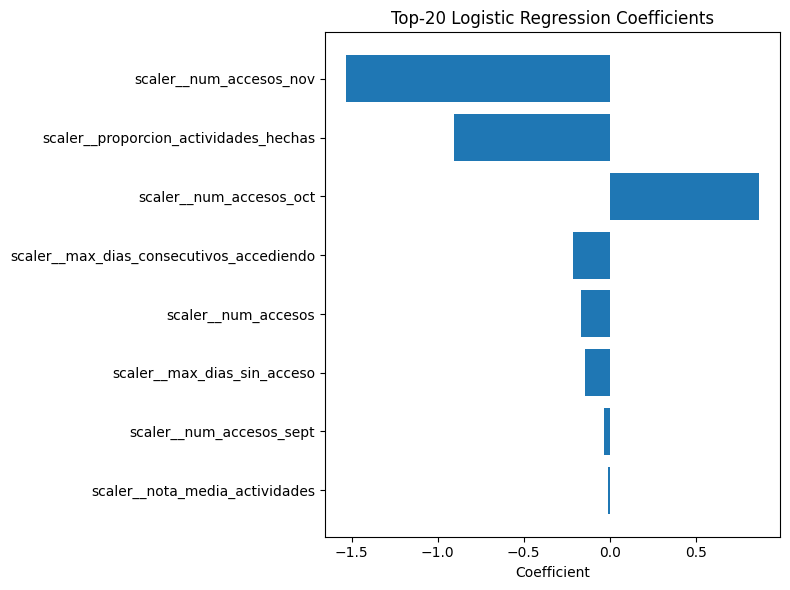

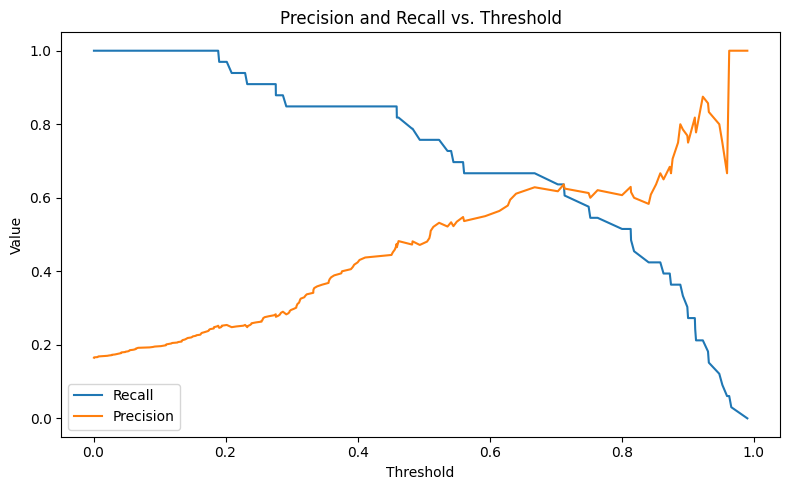

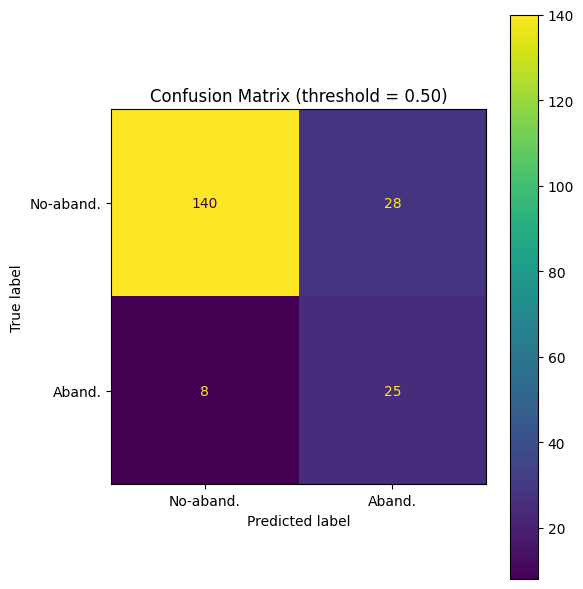

In [13]:
# Visualizar coeficientes de la regresión logística,
# Curva PR con umbrales y matriz de confusión

import joblib, os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# --- 1. Cargar modelo y datos ---------------------------------------------
pipeline = joblib.load(os.path.join(MODEL_PATH, "logreg.pkl"))
# Se asume que X, y están ya en memoria

y_prob = pipeline.predict_proba(X)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# --- 2. Coeficientes -------------------------------------------------------
feature_names = pipeline.named_steps["pre"].get_feature_names_out()
coef = pipeline.named_steps["clf"].coef_[0]
coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coef})
      .assign(abs_coef=lambda df: df.coef.abs())
      .sort_values("abs_coef", ascending=False)
)

print("LR Coefficients:")
display(coef_df[["feature", "coef"]])

# Gráfico Top‑20 coeficientes
plt.figure(figsize=(8,6))
plt.barh(coef_df.head(20)["feature"][::-1],
         coef_df.head(20)["coef"][::-1])
plt.xlabel("Coefficient")
plt.title("Top‑20 Logistic Regression Coefficients")
plt.tight_layout()
plt.show()
# --- 3. Curva Precision‑Recall con umbrales -------------------------------
precision, recall, thresholds = precision_recall_curve(y, y_prob)
ap = average_precision_score(y, y_prob)

fig, ax2 = plt.subplots(1, 1, figsize=(8, 5))

# Precision & Recall vs Threshold
# note thresholds aligns with precision[1:], recall[1:]
ax2.plot(thresholds, recall[1:], label="Recall")
ax2.plot(thresholds, precision[1:], label="Precision")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Value")
ax2.set_title("Precision and Recall vs. Threshold")
ax2.legend()

plt.tight_layout()
plt.show()

# --- 4. Matriz de confusión (threshold = 0.5) -----------------------------
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No‑aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title("Confusion Matrix (threshold = 0.50)")
plt.tight_layout()
plt.show()



# Probar métricas con umbral 0.75



Metrics at threshold = 0.7
F1-score : 0.647
Precision: 0.629
Recall   : 0.667
ROC AUC  : 0.874


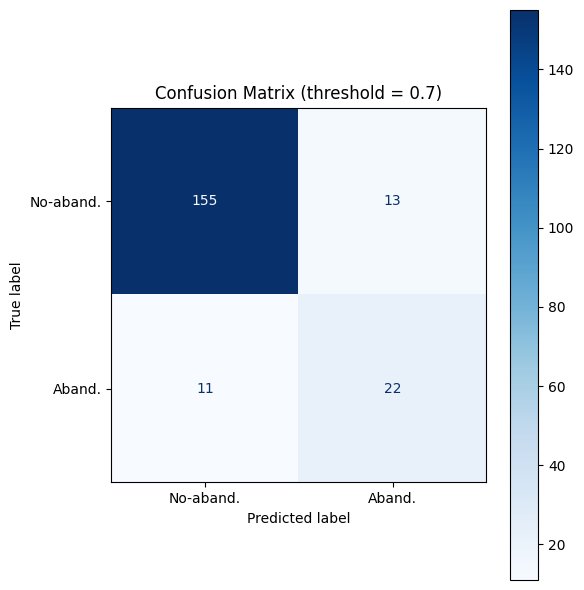

In [18]:
# ============================================================
# Métricas y matriz de confusión para threshold = 0.6
# ============================================================
import os, joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# 1) Cargar pipeline de regresión logística
model = joblib.load(os.path.join(MODEL_PATH, "logreg.pkl"))

# 2) Calcular probabilidades y predicciones con umbral 0.6
y_prob = model.predict_proba(X)[:, 1]
threshold = 0.70
y_pred_thr = (y_prob >= threshold).astype(int)

# 3) Calcular métricas
f1      = f1_score(y, y_pred_thr)
precision = precision_score(y, y_pred_thr)
recall  = recall_score(y, y_pred_thr)
roc_auc = roc_auc_score(y, y_prob)  # AUC no cambia con el threshold

print(f"Metrics at threshold = {threshold}")
print(f"F1-score : {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"ROC AUC  : {roc_auc:.3f}")

# 4) Mostrar matriz de confusión
cm = confusion_matrix(y, y_pred_thr)
disp = ConfusionMatrixDisplay(cm, display_labels=["No-aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.tight_layout()
plt.show()
